# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you):
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

You have to report all your work at the end of this notebook.



# Code

In [ ]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.

    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector

    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers

    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.

    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)

    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.

    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """

    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]

    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset

    :model: Model to be fit
    :X_train, y_train: Train samples and labels
    :X_test y_test: Test samples and labels
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """

    # Train the model
    history=model.fit(X_train, y_train,
                      validation_split= 0.1,
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])

    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()


def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):

    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

    states = [encoder_state_h, encoder_state_c]

    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')

    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))

    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h

    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = decoder_dense(decoder_outputs)

        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)

        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model, decoder_dense, decoder_lstm, encoder_lstm


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis,
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



In [ ]:
# dataset
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/150
18/18 [==============================] - 176s 3s/step - loss: 2.9633 - accuracy: 0.0538 - val_loss: 2.9471 - val_accuracy: 0.0491
Epoch 2/150
18/18 [==============================] - 5s 263ms/step - loss: 2.9455 - accuracy: 0.0547 - val_loss: 2.9440 - val_accuracy: 0.0551
Epoch 3/150
18/18 [==============================] - 5s 266ms/step - loss: 2.9432 - accuracy: 0.0609 - val_loss: 2.9411 - val_accuracy: 0.0640
Epoch 4/150
18/18 [==============================] - 5s 266ms/step - loss: 2.9387 - accuracy: 0.0668 - val_loss: 2.9370 - val_accuracy: 0.0672
Epoch 5/150
18/18 [==============================] - 5s 265ms/step - loss: 2.9323 - accuracy: 0.0707 - val_loss: 2.9322 - val_accuracy: 0.0731
Epoch 6/150
18/18 [==============================] - 5s 266ms/step - loss: 2.9240 - accuracy: 0.0764 - val_loss: 2.9229 - val_accuracy: 0.0801
Epoch 7/150
18/18 [==============================] - 5s 266ms/step - loss: 2.9172 - accuracy: 0.0804 - val_loss: 2.9156 - val_accuracy: 0.0815


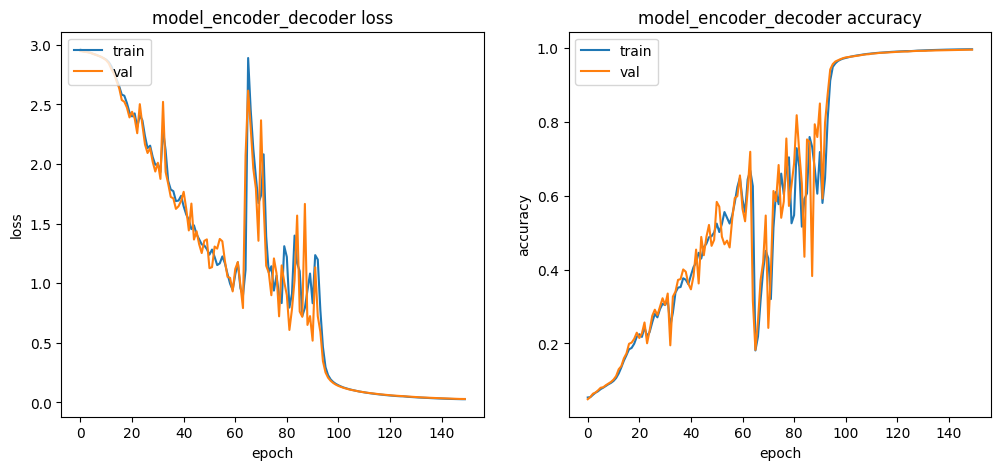

In [ ]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=150, patience=100)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        # Weights for the query (decoder hidden state)
        self.W1 = tf.keras.layers.Dense(units)
        # Weights for the values (encoder outputs)
        self.W2 = tf.keras.layers.Dense(units)
        # Weights for the attention scores
        self.V = tf.keras.layers.Dense(1)


    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        # Weight matrix for creating a "general" attention score
        self.W = tf.keras.layers.Dense(units)


    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])


        score = tf.transpose(tf.matmul(query_with_time_axis, self.W(values_transposed)), perm=[0, 2, 1])
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## Training & Validation/Testing of the three Models

Epoch 1/300
18/18 [==============================] - 189s 3s/step - loss: 2.9630 - accuracy: 0.0539 - val_loss: 2.9460 - val_accuracy: 0.0572
Epoch 2/300
18/18 [==============================] - 15s 840ms/step - loss: 2.9440 - accuracy: 0.0579 - val_loss: 2.9425 - val_accuracy: 0.0600
Epoch 3/300
18/18 [==============================] - 15s 831ms/step - loss: 2.9399 - accuracy: 0.0638 - val_loss: 2.9365 - val_accuracy: 0.0682
Epoch 4/300
18/18 [==============================] - 15s 810ms/step - loss: 2.9296 - accuracy: 0.0740 - val_loss: 2.9263 - val_accuracy: 0.0772
Epoch 5/300
18/18 [==============================] - 14s 804ms/step - loss: 2.9208 - accuracy: 0.0781 - val_loss: 2.9214 - val_accuracy: 0.0781
Epoch 6/300
18/18 [==============================] - 14s 804ms/step - loss: 2.9136 - accuracy: 0.0829 - val_loss: 2.9132 - val_accuracy: 0.0835
Epoch 7/300
18/18 [==============================] - 15s 814ms/step - loss: 2.9054 - accuracy: 0.0861 - val_loss: 2.9032 - val_accuracy: 0

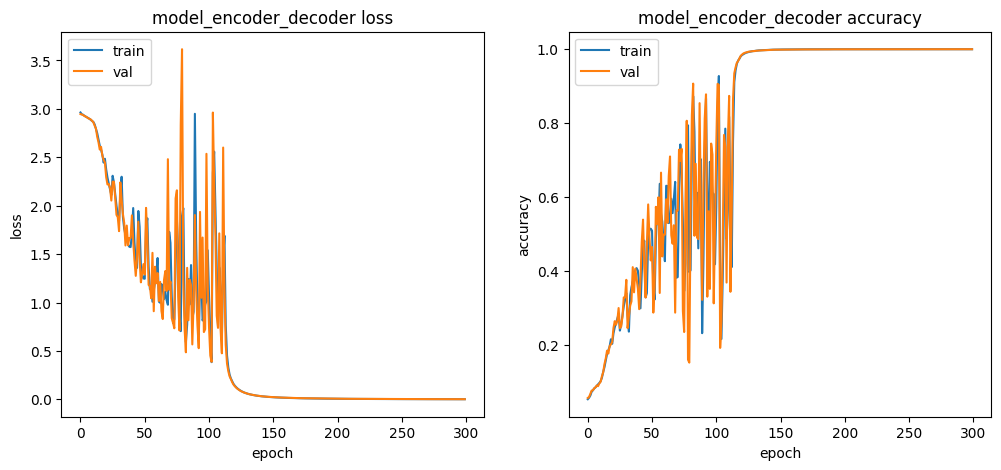

In [ ]:
bahdanau_attention = BahdanauAttention(rnn_units)
model_bahdanau, decoder_dense_b, decoder_lstm_b, encoder_lstm_b  = build_attention_model(bahdanau_attention, batch_size, rnn_units)
train_test(model_bahdanau, X_train, y_train, X_test, y_test, epochs=300, batch_size=batch_size, patience=20)

Epoch 1/300
18/18 [==============================] - 175s 2s/step - loss: 2.9632 - accuracy: 0.0553 - val_loss: 2.9480 - val_accuracy: 0.0515
Epoch 2/300
18/18 [==============================] - 5s 266ms/step - loss: 2.9451 - accuracy: 0.0553 - val_loss: 2.9429 - val_accuracy: 0.0673
Epoch 3/300
18/18 [==============================] - 5s 262ms/step - loss: 2.9409 - accuracy: 0.0629 - val_loss: 2.9394 - val_accuracy: 0.0595
Epoch 4/300
18/18 [==============================] - 5s 259ms/step - loss: 2.9343 - accuracy: 0.0710 - val_loss: 2.9280 - val_accuracy: 0.0770
Epoch 5/300
18/18 [==============================] - 5s 265ms/step - loss: 2.9217 - accuracy: 0.0791 - val_loss: 2.9160 - val_accuracy: 0.0817
Epoch 6/300
18/18 [==============================] - 5s 255ms/step - loss: 2.9088 - accuracy: 0.0851 - val_loss: 2.9044 - val_accuracy: 0.0883
Epoch 7/300
18/18 [==============================] - 5s 267ms/step - loss: 2.8992 - accuracy: 0.0900 - val_loss: 2.8967 - val_accuracy: 0.0903


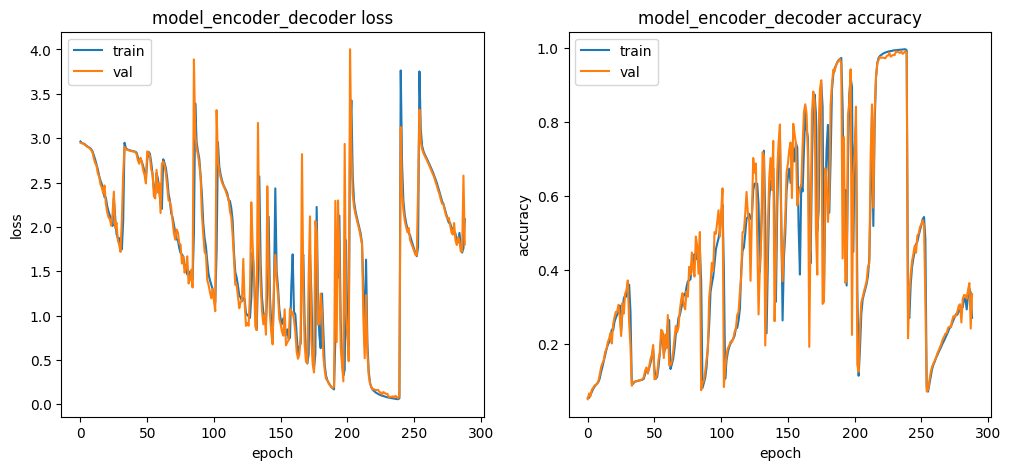

In [ ]:
dot_attention = LuongDotAttention()
model_dot, decoder_dense_dot, decoder_lstm_dot, encoder_lstm_dot  = build_attention_model(dot_attention, batch_size, rnn_units)
train_test(model_dot, X_train, y_train, X_test, y_test, epochs=300, batch_size=batch_size, patience=50)

Epoch 1/300
18/18 [==============================] - 12s 660ms/step - loss: 2.9454 - accuracy: 0.0569 - val_loss: 2.9448 - val_accuracy: 0.0555
Epoch 3/300
18/18 [==============================] - 12s 666ms/step - loss: 2.9422 - accuracy: 0.0604 - val_loss: 2.9393 - val_accuracy: 0.0683
Epoch 4/300
18/18 [==============================] - 12s 650ms/step - loss: 2.9338 - accuracy: 0.0708 - val_loss: 2.9258 - val_accuracy: 0.0776
Epoch 5/300
18/18 [==============================] - 12s 646ms/step - loss: 2.9198 - accuracy: 0.0810 - val_loss: 2.9059 - val_accuracy: 0.0903
Epoch 6/300
18/18 [==============================] - 12s 656ms/step - loss: 2.8945 - accuracy: 0.0940 - val_loss: 2.8781 - val_accuracy: 0.1016
Epoch 7/300
18/18 [==============================] - 12s 644ms/step - loss: 2.8596 - accuracy: 0.1081 - val_loss: 2.8397 - val_accuracy: 0.1119
Epoch 8/300
18/18 [==============================] - 12s 657ms/step - loss: 2.8560 - accuracy: 0.1078 - val_loss: 2.8401 - val_accuracy:

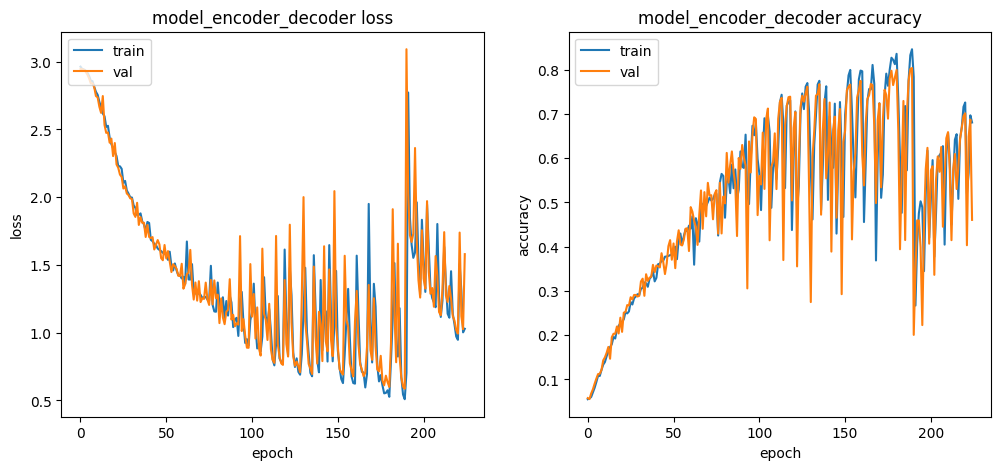

In [ ]:
luong_general_attention = LuongGeneralAttention(rnn_units)
model_luong_general, decoder_dense_general, decoder_lstm_general, encoder_lstm_general = build_attention_model(luong_general_attention, batch_size, rnn_units)
train_test(model_luong_general, X_train, y_train, X_test, y_test, epochs=300, batch_size=batch_size, patience=35)

## Visualization Function

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def perform_evaluation(input_sequence, encoder_lstm, decoder_lstm, final_dense_layer, attention_mechanism):
    # Prepare attention matrix for visualization and preprocess the input sequence
    attn_matrix = np.zeros((n_timesteps_in, n_timesteps_in))
    encoded_seq = one_hot_encode(input_sequence, n_features)

    # Run the encoder
    encoder_input_tensor = np.array(encoded_seq).reshape(1, n_timesteps_in, n_features)
    encoder_input_tensor = tf.cast(encoder_input_tensor, tf.float32)
    enc_outputs, enc_hidden_state, enc_cell_state = encoder_lstm(encoder_input_tensor)

    decoder_hidden = enc_hidden_state
    decoder_cell_states = [enc_hidden_state, enc_cell_state]
    decoder_predictions = []

    # Decoder - process one timestep at a time
    dec_input_data = np.zeros((1, 1, n_features))
    dec_input_data[:, 0, 0] = 1
    dec_inputs = dec_input_data

    for t in range(n_timesteps_in):
        attn_context_vector, attn_weights = attention_mechanism(decoder_hidden, enc_outputs)
        attn_context_vector = tf.expand_dims(attn_context_vector, 1)
        dec_inputs = tf.concat([attn_context_vector, dec_inputs], axis=-1)

        # Save attention weights for later visualization
        attn_weights = tf.reshape(attn_weights, (-1, ))
        attn_matrix[t] = attn_weights.numpy()

        # Concatenate and pass to LSTM
        decoder_hidden = tf.expand_dims(decoder_hidden, 1)
        decoder_hidden, dec_hidden_state, dec_cell_state = decoder_lstm(dec_inputs, initial_state=decoder_cell_states)
        predictions = final_dense_layer(decoder_hidden)
        predictions = tf.expand_dims(predictions, 1)
        decoder_predictions.append(predictions)

        dec_inputs = predictions
        decoder_cell_states = [dec_hidden_state, dec_cell_state]

    decoder_output_tensor = Lambda(lambda x: K.concatenate(x, axis=1))(decoder_predictions)
    translated_sequence = one_hot_decode(decoder_output_tensor[0])

    return input_sequence, translated_sequence, attn_matrix

def visualize_attention_weights(attn_weights, original_seq, pred_seq):
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(attn_weights, cmap='Greys_r')  # Change color map to Greys for black-to-white scale
    fig.colorbar(cax)

    # Set up labels for ticks
    ax.set_xticklabels([''] + original_seq, rotation=90)
    ax.set_yticklabels([''] + list(reversed(pred_seq)))  # Reverse the predicted sequence for y-axis flip
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Flip the y-axis so the first entry is at the top
    ax.invert_yaxis()  # Inverts the y-axis to flip it

    plt.show()


def perform_translation(input_sequence, encoder_lstm, decoder_lstm, final_dense_layer, attention_mechanism):
    original_seq, predicted_seq, attn_plot = perform_evaluation(input_sequence, encoder_lstm, decoder_lstm, final_dense_layer, attention_mechanism)
    attn_plot = attn_plot[:len(predicted_seq), :len(original_seq)]
    visualize_attention_weights(attn_plot, original_seq, predicted_seq)



# Report



The following are the test accuracies (1-error rate) and the each the amount of epochs used by the Models. Bahdanau Attention Scoring outperformed both the Luong Dot Model and the Luong General Attention class. The Luong Dat attention needed slightly more epochs to converge than the Luong General Attention but at the same time strongly outperformed it in testing. The Bahdanau technically never converged even after 300 epochs, 1.5 hours of training and and test accuracy of 100%. But since the differences in the last epochs were miniscule and especially in the last 5 epochs the loss functions did not change their value at all, it would be natural that also this Model would soon have completely finally converged, but which would anyways would make little difference with a test score already at 1.0000.

So in Summary, the while th Luong General Attention by far converged the fastest, it also underperformed the other two models strongly. While the Luong Dot Attention converged slightly faster than the Bahdanau, it still underperformed it slightly in the test accuracies.

  | Name | Test Accuracy | Epochs Used |
  |----------|----------|----------|
  | Bahdanau Attention | 1.0000 | 300 |
  | Luong Dot Attention | 0.9931 | 289 |
  | Luong General Attention | 80.480 | 225 |


In the following now are the visualisations of each attention weight of the Models with a black and white attention plot, exactly shown as the example given in the Instructions. With each Model the distribution of the weights gets increasingly better, with that of Bahdanau being in the End exactly as wished.


### Luong General Attention Visualization

<ipython-input-20-ea1d6208cb48>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + original_seq, rotation=90)
<ipython-input-20-ea1d6208cb48>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(reversed(pred_seq)))  # Reverse the predicted sequence for y-axis flip


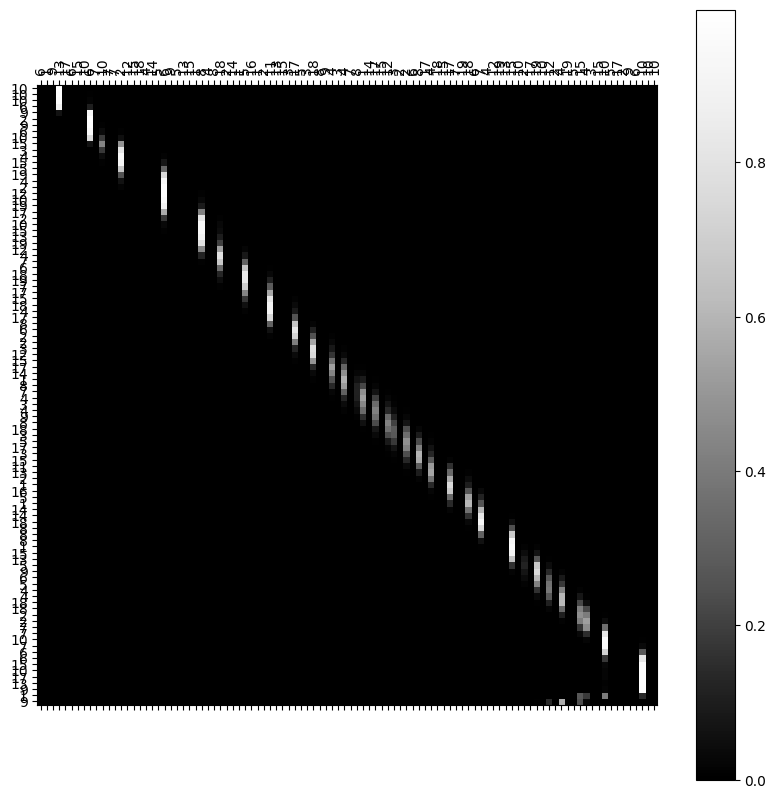

In [ ]:
perform_translation(generate_sequence(n_timesteps_in, n_features), encoder_lstm_general, decoder_lstm_general, decoder_dense_general, luong_general_attention)

### Luong Dot Attention Visualization

<ipython-input-12-ea1d6208cb48>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + original_seq, rotation=90)
<ipython-input-12-ea1d6208cb48>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(reversed(pred_seq)))  # Reverse the predicted sequence for y-axis flip


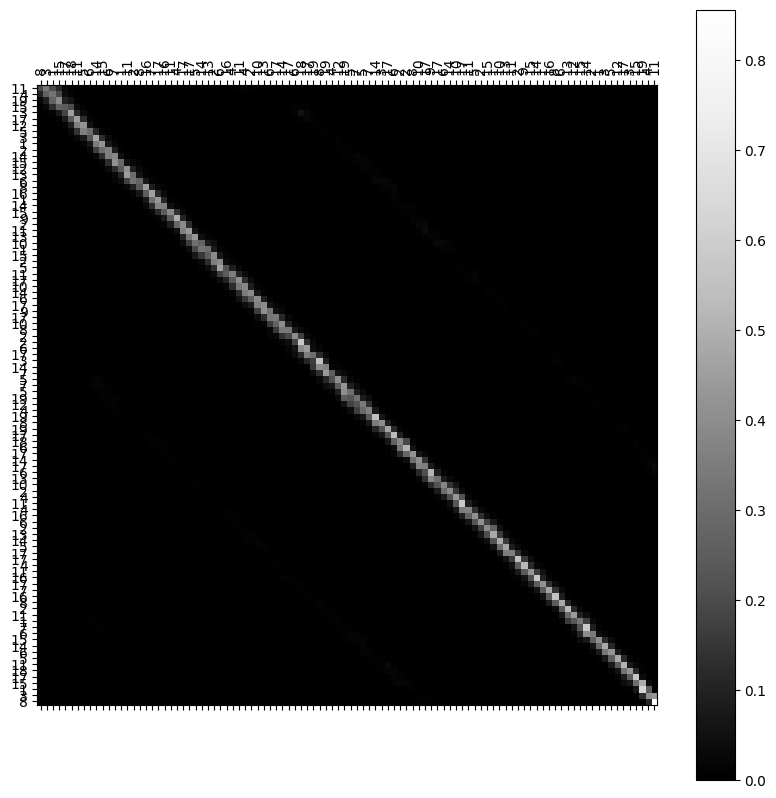

In [ ]:
perform_translation(generate_sequence(n_timesteps_in, n_features), encoder_lstm_dot, decoder_lstm_dot, decoder_dense_dot, dot_attention)

### Bahdanau Attention Visualization

<ipython-input-7-ea1d6208cb48>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + original_seq, rotation=90)
<ipython-input-7-ea1d6208cb48>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(reversed(pred_seq)))  # Reverse the predicted sequence for y-axis flip


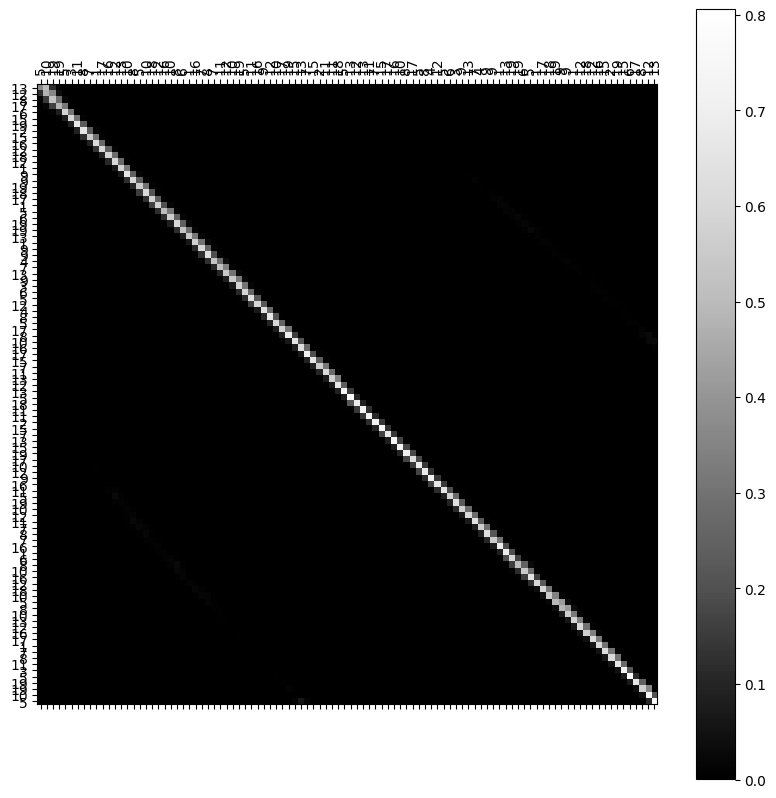

In [ ]:
perform_translation(generate_sequence(n_timesteps_in, n_features), encoder_lstm_b, decoder_lstm_b, decoder_dense_b, bahdanau_attention)